## Data analysis

In [1]:
#from utils import *
#from lin_GAN_penny_script import *
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import random
import time
import datetime
from tqdm import tqdm
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# dataloader = torch.utils.data.DataLoader(rd, batch_size=1, shuffle=True, drop_last=True)

# for elem in dataloader:
#     plt.imshow(elem[0][0])

#show_images(GAN_imgs[0], 20)

#show_images(QGAN_imgs[100:150], 20)

In [4]:
# Plotting histogram probability distributions 

# linear_gan_synthetic = np.concatenate(GAN_imgs).reshape(len(GAN_imgs), 8, 8)
# reshaped_linear_gan_synthetic = linear_gan_synthetic.reshape(len(GAN_imgs)*64)
# linear_qgan_synthetic = np.concatenate(QGAN_imgs).reshape(len(QGAN_imgs), 8, 8)
# reshaped_linear_qgan_synthetic = linear_qgan_synthetic.reshape(len(QGAN_imgs)*64)
# real_data = np.concatenate(real_img).reshape(len(real_img), 8, 8)
# reshaped_real_data = real_data.reshape(len(real_data)*64)

# empty_dataframe = pd.DataFrame(columns=['Real data','GAN', 'QGAN'])
# df1 = pd.DataFrame(reshaped_real_data)
# df2 = pd.DataFrame(reshaped_linear_gan_synthetic)
# df3 = pd.DataFrame(reshaped_linear_qgan_synthetic)
# df = pd.concat([df1, df2, df3], 1)
# df.columns = ['Real data','GAN', 'QGAN']

# sns.displot(data = df, kind = 'kde')

In [5]:
def resize_data_one_hot(x, y, label, image_size, num_classes):

    arr = []
    arr_input = []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
            arr.append((t, lab))
            arr_input.append(t)
    return arr, arr_input


def split_train_test(real_data, idx, num_classes):

    train_data, test_data = [], []

    for i, (img, label) in enumerate(real_data):

        if i < idx:

            # one hot enoding for training labels
            lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
            #print('img shape train data: ', img.shape)
            train_data.append((img, lab))
        
        else:
            
            lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
            test_data.append((img, lab))

    return train_data, test_data



def build_dataset(model_type, noise_dim, path, len_real_data, labels, num_classes, max_epoch):

    if model_type == 'Classical_linear':

        GAN_imgs, dataset, idx = [], [], 0      

        # r=root, d=directories, f=files
        for r, d, f in os.walk(path): 
            #print('directory: ', d)
            #print(f)                 
            for file in f:                 
                if file.endswith(f"lin_gen_epoch_{max_epoch}"):    

                    #print(os.path.join(r, file))                       
                    model = torch.load(os.path.join(r, file))
                    model.eval()

                    for _ in range(500):      
                
                        image = model(torch.rand(1, noise_dim)).view(8,8).cpu().detach()
                        #print('img shape: ', image.shape)
                        # plt.imshow(image, cmap='gray')
                        # plt.show()
                        # time.sleep(0.1)
                        GAN_imgs.append(image)
                        label = torch.nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=num_classes)
                        dataset.append((image, label))                    
                        
                    idx += 1

                    #print('FINISH', len(GAN_imgs))
                    

    elif model_type == 'Quantum_linear':

        GAN_imgs, dataset, idx = [], [], 0  
    
        for r, d, f in os.walk(path):               
            for file in f:                     
                if file.endswith(f"lin_q_gen_epoch_{max_epoch}"):  

                    model = torch.load(os.path.join(r, file))    
                    model.eval()               

                    for k in range(500):   

                        image = model(torch.rand(1, noise_dim)).view(8,8).cpu().detach()
                      
                        GAN_imgs.append(image.shape)
                        label = torch.nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=num_classes)
                        dataset.append((image, label))
                        
                    idx += 1                
    
    else:

        print('Network typology not admitted.')

    return GAN_imgs, dataset



class Classificator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 'same')
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.flatten(x,1) # flatten all dimensions except batch
        #print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)


def training_classification(classificator, train_dataloader, epochs, learning_rate, batch_size, path):

    optimizer = torch.optim.SGD(classificator.parameters(),lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    episode_loss = []
    tot_loss_mean = []

    with tqdm(range(epochs)) as tepochs:

        for epoch in tepochs:  

            running_loss = 0.0
            for i, data in enumerate(train_dataloader):

                #(train, label) = data
                #print(data[0].shape)
                #print(data[1].shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = classificator(data[0].view(batch_size,1,8,8))#(data[0].size(0), -1))
                #print('Outputs training: ', outputs.shape)

                label = data[1].float()

                #print('Label: ', label.shape)

                loss = loss_fn(outputs, label)
                #print(loss)
                loss.backward()
                optimizer.step()

                episode_loss.append(loss.item())

                # print statistics
                running_loss += loss.item()
                
                tepochs.set_postfix({'Classificator loss' : loss.item()})
            
            tot_loss_mean.append(np.mean(episode_loss))

            torch.save(classificator.state_dict(), path + 'classificator.pt')

    return tot_loss_mean            



def evaluate_accuracy(classificator, test_dataloader, batch_size, path):

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_dataloader:
            
            labels = data[1]
            print('labels: ', labels)

            #print('Data:', data[0].shape)

            classificator.load_state_dict(torch.load(path + 'classificator.pt'))
            
            outputs = classificator(data[0].view(batch_size,1,8,8))#.view(data.size(0), -1)
            print('Output data: ', outputs.data)

            a, predicted = torch.max(outputs.data, 1)
            print(a)
            print('pred: ', predicted)

            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
            #print('correct', correct)

    #print('total', total)

    #print(f'Accuracy on the {total} test images: {100 * correct / total} %')

    return 100 * correct / total



def training_run(model_type, classificator, dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True):

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if model_type == 'Classical_linear':
        
        save_path = 'torch_results/Classificator/GAN_data/' + current_time + '/'

    elif model_type == 'Quantum_linear':

        save_path = 'torch_results/Classificator/QGAN_data/' + current_time + '/'
    
    else:
        print('Model typology not admitted.')
    summary_writer = tf.summary.create_file_writer(save_path)

    loss_synthetic = training_classification(classificator, dataloader, epochs, learning_rate, batch_size, save_path)
    acc_synthetic = evaluate_accuracy(classificator, real_dataloader, batch_size, save_path)

    if reset_parameters:
        for layer in classificator.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
    
    return acc_synthetic, loss_synthetic


def multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True):

    acc_tot = []
    q_acc_tot = []
    loss_tot = []
    q_loss_tot = []

    for run in range(runs):

        print(f'---------------------------------------- RUN {run+1} ----------------------------------------')
        
        print('Classical GAN training: ')
        classical_accuracy, classical_loss = training_run(model_type[0], c_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True)
        #print(classical_accuracy)

        print('Quantum GAN training: ')
        quantum_accuracy, quantum_loss = training_run(model_type[1], q_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True)

        acc_tot.append(classical_accuracy)
        q_acc_tot.append(quantum_accuracy)
        loss_tot.append(classical_loss)
        q_loss_tot.append(quantum_loss)

    c_acc_mean = np.mean(acc_tot)
    c_acc_std = np.std(acc_tot)
    q_acc_mean = np.mean(q_acc_tot)    
    q_acc_std = np.std(q_acc_tot)

    c_loss_mean = np.mean(loss_tot)
    c_loss_std = np.std(loss_tot)
    q_loss_mean = np.mean(q_loss_tot)    
    q_loss_std = np.std(q_loss_tot)

    delta_acc = [np.abs(acc_tot[i]-q_acc_tot[i]) for i in range(len(acc_tot))]

    dict = {'GAN_data_accuracy': [acc_tot], 'QGAN_data_accuracy': [q_acc_tot]}  
       
    df = pd.DataFrame(dict)         
    # saving the dataframe 
    df.to_csv(f'torch_results/Metrics/Classification_accuracies_{2}_labels.csv')

    return acc_tot, q_acc_tot, delta_acc, c_loss_mean, q_loss_mean#, c_acc_mean, c_acc_std, q_acc_mean, q_acc_std, c_loss_std, , q_loss_std

In [6]:
def show_images(data, n_samples):

    plt.figure(figsize=(8,2))

    for i in range(n_samples):
        image = data[i][0]#.reshape(8, 8)
        plt.subplot(1,n_samples,i+1)
        plt.axis('off')
        plt.imshow(image.numpy(), cmap='gray')
        
    plt.show()

/tmp/ipykernel_2919/1331766115.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
/tmp/ipykernel_2919/1331766115.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)


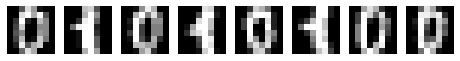

(1797, 360, 288, 72)

In [7]:
noise_dim = 5
image_size = 8
model_type = ['Classical_linear', 'Quantum_linear']
labels = [0,1]
num_classes = len(labels)
runs = 2
epochs = 10
batch_size = 4
learning_rate = 0.01
#num_classes = 2

# Showing real data
digits, targets = datasets.load_digits(return_X_y =True)
digits = digits.reshape(len(digits), 8, 8)

# Selecting only specific labels
real_data, real_img = resize_data_one_hot(digits, targets, label=(0,1), image_size=image_size, num_classes=num_classes)

# Splitting train-test data (one-hot encoding included)
idx = int(len(real_data)*0.8)
train_data, test_data = split_train_test(real_data, idx, num_classes=num_classes)
show_images(real_data, 8)
len(digits), len(real_data), len(train_data), len(test_data)

In [8]:
real_data

[(tensor([[0.0000, 0.0000, 0.3125, 0.8125, 0.5625, 0.0625, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.8125, 0.9375, 0.6250, 0.9375, 0.3125, 0.0000],
          [0.0000, 0.1875, 0.9375, 0.1250, 0.0000, 0.6875, 0.5000, 0.0000],
          [0.0000, 0.2500, 0.7500, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
          [0.0000, 0.3125, 0.5000, 0.0000, 0.0000, 0.5625, 0.5000, 0.0000],
          [0.0000, 0.2500, 0.6875, 0.0000, 0.0625, 0.7500, 0.4375, 0.0000],
          [0.0000, 0.1250, 0.8750, 0.3125, 0.6250, 0.7500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3750, 0.8125, 0.6250, 0.0000, 0.0000, 0.0000]]),
  tensor([[1, 0],
          [0, 1]])),
 (tensor([[0.0000, 0.0000, 0.0000, 0.7500, 0.8125, 0.3125, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.6875, 1.0000, 0.5625, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1875, 0.9375, 1.0000, 0.3750, 0.0000, 0.0000],
          [0.0000, 0.4375, 0.9375, 1.0000, 1.0000, 0.1250, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0625, 1.0000, 1.00

In [9]:
#-------------------------------------------------------- Making inference --------------------------------------------------------
len_real_data = len(real_data)

# Bulding synthetic classical dataset (one-hot encoding included)
path = "torch_results/GAN/GAN_linear"
GAN_imgs, synthetic_classical_data = build_dataset(model_type[0], noise_dim, path, len_real_data, labels, num_classes, max_epoch=2)

# Bulding synthetic quantum dataset (one-hot encoding included)
q_path = "torch_results/QGAN/QGAN_linear"
QGAN_imgs, synthetic_quantum_data = build_dataset(model_type[1], noise_dim, q_path, len_real_data, labels, num_classes, max_epoch=2)

AttributeError: Can't get attribute 'Generator' on <module '__main__'>

In [ ]:
# plt.imshow(synthetic_classical_data[999][0], cmap='gray')
# plt.imshow(synthetic_classical_data[999][0], cmap='gray')

In [ ]:
real_dataloader = DataLoader(real_data, batch_size=batch_size, shuffle=True, drop_last=True)
synthetic_dataloader = DataLoader(synthetic_classical_data, batch_size=batch_size, shuffle=True, drop_last=True)
q_synthetic_dataloader = DataLoader(synthetic_quantum_data, batch_size=batch_size, shuffle=True, drop_last=True)

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=True, drop_last=True)

In [ ]:
for elem in real_dataloader:
    print(elem[1])

In [ ]:
################################## Real data ##################################

# r_classificator_path = 'torch_results/Classificator/Real_data/' + current_time + '/'
# summary_writer = tf.summary.create_file_writer(r_classificator_path)
# r_classificator = Classificator(num_classes)

# learning_rate = 0.01
# classical_loss_real = training_classification(r_classificator, train_dataloader, epochs, learning_rate, batch_size, r_classificator_path)
# acc_real = evaluate_accuracy(r_classificator, test_dataloader, batch_size, r_classificator_path)
# acc_real

In [ ]:
c_classificator = Classificator(num_classes)
q_classificator = Classificator(num_classes)

acc_tot, q_acc_tot, delta_acc, c_loss, q_loss = multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, 
                                                              real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True) 

In [ ]:
acc_final = []
loss_final = []
q_acc_final = []
q_loss_final = []

acc_final.append(acc_tot)
q_acc_final.append(q_acc_tot)
acc_final, q_acc_final#, delta_acc

In [ ]:
def accuracy_boxplot(acc_final, q_acc_final, labels, num_tests):

    fig, ax = plt.subplots(figsize=(12, 6), facecolor='oldlace')

    for i in range(num_tests):
    
        boxes = ax.boxplot(acc_final[i], patch_artist=True, showmeans = False, showfliers=False, widths = 0.42, labels = labels)
        for box in boxes["boxes"]:
            box.set(facecolor = "green")

        q_boxes = ax.boxplot(q_acc_final[i], patch_artist=True, showmeans = False, showfliers=False, widths = 0.32, labels = labels)
        for box in q_boxes["boxes"]:
            box.set(facecolor = "palegreen")

        fig.text(0.92, 0.73, f'GAN linear\nGen: 204 params\nDisc: 5127 params', backgroundcolor='green', color='black', weight='roman')
        fig.text(0.92, 0.63, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='palegreen', color='black', weight='roman')
        #fig.text(0.92, 0.52, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='darkkhaki', color='black', weight='roman')
        #fig.text(0.92, 0.52, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='palegoldenrod', color='black', weight='roman')

        ax.set_xlabel('Number of digits labels', fontsize=16)
        ax.set_ylabel('Accuracy score', fontsize=16)
        plt.grid()
        plt.title(f"Accuracy classification score - Handwritten 8x8 dataset", fontsize=18)
        plt.savefig(f'torch_results//Metrics/Classification_accuracies_{3}_labels.png')
        plt.show()

In [ ]:
labels = [2, 3]
boxplot = accuracy_boxplot(acc_final, q_acc_final, labels, 2)
boxplot

In [ ]:
# dict = {'Real_data_acc': [acc_real], 'GAN_data_acc': [acc_synthetic], 'QGAN_data_acc': [acc_q_synthetic]}  
       
# df = pd.DataFrame(dict) 
    
# # saving the dataframe 
# df.to_csv(f'torch_results/Metrics/Classification_accuracies_{len(labels)}_labels.csv')


# data = {'GAN 204 params':acc_synthetic, 'QGAN 120 params':acc_q_synthetic}
# courses = list(data.keys())
# values = list(data.values())

# label1 = [np.round(acc_synthetic, 3)]
# label2 = [np.round(acc_q_synthetic, 3)]
  
# fig = plt.figure(figsize = (13, 9))
 
# # creating the bar plot
# plt.bar(courses, values, color = ['blue', 'red'], data = [acc_synthetic, acc_q_synthetic])
# plt.text(x = -0.06 , y = data['GAN 204 params'] + 0.5, s = label1[0], size = 15)
# plt.text(x = 0.94 , y = data['QGAN 120 params'] + 0.6, s = label2[0], size = 15) 
# plt.ylabel("Accuracy", fontsize=18)
# plt.title(f"Accuracy classification score - Handwritten 8x8 dataset - {len(labels)} labels", fontsize=18)
# plt.savefig(f'torch_results//Metrics/Classification_accuracies_{len(labels)}_labels.png')
# plt.show()


# plt.figure(figsize=(10, 7))
# #plt.plot(np.arange(epochs), classical_loss_real[:epochs], label = 'Train: real data\nTest:real data')
# plt.plot(np.arange(epochs), classical_loss_synthetic[:epochs], label = 'Train: synthetic classical data\nTest: real data')
# plt.plot(np.arange(epochs), quantum_loss_synthetic[:epochs], label = 'Train: synthetic quantum data\nTest: real data')
# plt.title(f'Classification training loss - {len(labels)} labels')
# plt.legend()
# plt.savefig(f'torch_results//Metrics/Classification_loss_{len(labels)}_labels.png')
# plt.show()
